Lab 05 - Clusterização e Mineração de Texto

Thais Damasceno Silva - 11721BCC007

1) O dataset será o poema épico Os Lusíadas:
https://github.com/rlafuente/textan/blob/master/sources/lusiadas.txt

In [115]:
# Leitura do arquivo lusiadas.txt baixado em: https://github.com/rlafuente/textan/blob/master/sources/lusiadas.txt
with open("lusiadas.txt", "r", encoding="latin-1") as file:
    full_text = file.read()

# Marcador de fim do poema
end_marker = "---------------------oOo---------------------"
if end_marker in full_text:
    poem_text = full_text.split(end_marker)[0].strip() # Separa o texto do poema antes do marcador e remove espaços extras
else:
    raise ValueError("Marcador de fim não encontrado no texto.")

# Dividir o texto do poema em estrofes, que são separadas por uma linha contendo números, conforme o padrão do arquivo
estrofes = re.split(r"\n\s*\d+\s*\n", poem_text) # A expressão r"\n\s*\d+\s*\n" corresponde a uma nova linha com um número seguido de espaços
estrofes = [e.strip() for e in estrofes if e.strip()] #remove espaços extras no começo e no final de cada estrofe

# Verifica se o número de estrofes extraídas é igual ou maior que 156
if len(estrofes) < 156:
    raise ValueError(f"Apenas {len(estrofes)} estrofes encontradas, mas 156 eram esperadas.")

# Caso o número de estrofes seja maior ou igual a 156, limitamos a lista de estrofes para as 156 primeiras
estrofes = estrofes[:156]


2) O poema tem 156 estrofes. Gere embeddings para cada uma delas.

embeddings foram gerados usando TF-IDF

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Stopwords em português
stop_words = stopwords.words('portuguese')

# Vetorização com TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_tfidf = vectorizer.fit_transform(estrofes)  # shape: (156, vocabulário)

# visualizar o shape dos embeddings
print(f"Shape dos embeddings TF-IDF: {X_tfidf.shape}")


Shape dos embeddings TF-IDF: (156, 2314)


3) Aplique o algoritmo de agrupamento k-Means (usando sklearn.cluster.KMeans) ou DBSCAN para agrupar as estrofes. Justifique a escolha.

**Algoritmo escolhido: KMeans**

**Justificativa:**

* **TF-IDF** gera uma representação esparsa e de alta dimensão, o que dificulta o uso eficaz do DBSCAN (por causa da métrica de distância).
* KMeans funciona melhor em espaços vetoriais como o TF-IDF, e com poucos dados (156 estrofes), é rápido e eficiente.
* Pode usar o silhouette score para escolher o melhor número de clusters, o que não é possível em DBSCAN com tanta clareza.

---


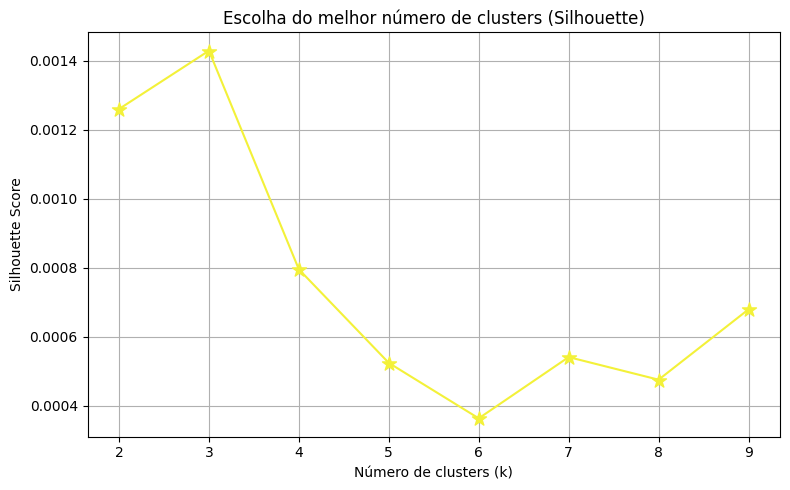

Silhouette Score para k = 3: 0.0014
Melhor número de clusters (baseado no Silhouette Score): 3


In [123]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Testar diferentes quantidades de clusters
scores = []
range_n = range(2, 10)

for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_tfidf)
    scores.append(silhouette_score(X_tfidf, labels))


# Plotar silhouette score
plt.figure(figsize=(8, 5))

# Silhouette Score
plt.plot(range_n, scores, marker='$\star$' ,color="#f3f139", markersize=10)
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Escolha do melhor número de clusters (Silhouette)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Melhor número de clusters baseado no Silhouette Score
best_k = range_n[np.argmax(scores)]
print(f"Silhouette Score para k = {best_k}: {scores[np.argmax(scores)]:.4f}")
print(f"Melhor número de clusters (baseado no Silhouette Score): {best_k}")


4) Discuta os resultados (quais as estrofes mais parecidas? quantos grupos parece haver? há outliers? etc)

**Melhor Número de Clusters (k = 3)**

O valor do Silhouette Score sugere que k = 3 é o melhor número de clusters, mas o score baixo indica que os clusters não são bem diferenciados, sugerindo que a separação entre os dados é fraca.

**Estrofes Mais Parecidas**

Embora o k = 3 indique clusters, a fraca separação entre eles dificulta uma clara distinção entre estrofes. Estrofes mais semelhantes provavelmente estão no mesmo cluster, mas pode haver sobreposição significativa entre grupos diferentes.

**Número de Grupos e Outliers**

Apesar de k = 3 ser o número de clusters identificado, a baixa coesão e separação indicam que os grupos não são semanticamente distintos. Outliers podem estar distorcendo a formação dos clusters e reduzindo a coesão.

**Conclusão**

O número de clusters k = 3 não resulta em grupos bem definidos, com possíveis sobreposições. A separação fraca sugere que o número ideal de clusters pode ser diferente, e a presença de outliers pode estar afetando o modelo de clustering.


In [118]:
# Rodar KMeans final com o melhor k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels_final = kmeans_final.fit_predict(X_tfidf)

# Agrupar estrofes por rótulo de cluster
from collections import defaultdict

clusters = defaultdict(list)
for idx, label in enumerate(labels_final):
    clusters[label].append((idx, estrofes[idx]))

# Mostrar 2 estrofes de cada cluster
for cluster_id, estrofes_do_cluster in clusters.items():
    print(f"\nCluster {cluster_id} ({len(estrofes_do_cluster)} estrofes):")
    for idx, estrofe in estrofes_do_cluster[:2]:  # mostrar só 2 para não poluir
        print(f"\nEstrofe {idx + 1}:\n{estrofe}\n{'-'*50}")



Cluster 2 (36 estrofes):

Estrofe 1:
1
As armas e os barões assinalados,
Que da ocidental praia Lusitana,
Por mares nunca de antes navegados,
Passaram ainda além da Taprobana,
Em perigos e guerras esforçados,
Mais do que prometia a força humana,
E entre gente remota edificaram
Novo Reino, que tanto sublimaram;
--------------------------------------------------

Estrofe 4:
E vós, Tágides minhas, pois criado
Tendes em mim um novo engenho ardente,
Se sempre em verso humilde celebrado
Foi de mim vosso rio alegremente,
Dai-me agora um som alto e sublimado,
Um estilo grandíloquo e corrente,
Porque de vossas águas, Febo ordene
Que não tenham inveja às de Hipoerene.
--------------------------------------------------

Cluster 1 (61 estrofes):

Estrofe 2:
E também as memórias gloriosas
Daqueles Reis, que foram dilatando
A Fé, o Império, e as terras viciosas
De África e de Ásia andaram devastando;
E aqueles, que por obras valerosas
Se vão da lei da morte libertando;
Cantando espalharei por toda 

5) Analise a cardinalidade, magnitude, coesão e separação dos agrupamentos.

In [119]:
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter

# Cardinalidade
contagem = Counter(labels_final)
print("\nCardinalidade por cluster:")
for cluster_id, qtd in contagem.items():
    print(f"Cluster {cluster_id}: {qtd} estrofes")

# Magnitude (distância média ao centróide)
_, distances = pairwise_distances_argmin_min(X_tfidf, kmeans_final.cluster_centers_)
avg_dist_per_cluster = {i: np.mean(distances[labels_final == i]) for i in range(best_k)}
print("\nMagnitude (distância média ao centróide):")
for cluster_id, dist in avg_dist_per_cluster.items():
    print(f"Cluster {cluster_id}: {dist:.4f}")

# Coesão (silhouette médio por cluster)
silhouette_vals = silhouette_samples(X_tfidf, labels_final)
print("\nCoesão (silhouette médio por cluster):")
for i in range(best_k):
    media_cluster = np.mean(silhouette_vals[labels_final == i])
    print(f"Cluster {i}: {media_cluster:.4f}")

# Separação (distância entre centróides)
dist_centr = euclidean_distances(kmeans_final.cluster_centers_)
print("\nMatriz de separação (distância entre centróides):")
print(np.round(dist_centr, 2))

# Variância intra-cluster
from sklearn.metrics import pairwise_distances
distances_intra = pairwise_distances(X_tfidf.toarray(), kmeans_final.cluster_centers_)
avg_variance_intra = np.mean(distances_intra, axis=0)
print("\nVariância intra-cluster (distância média de cada ponto ao centroide):")
for i, var in enumerate(avg_variance_intra):
    print(f"Cluster {i}: {var:.4f}")



Cardinalidade por cluster:
Cluster 2: 36 estrofes
Cluster 1: 61 estrofes
Cluster 0: 59 estrofes

Magnitude (distância média ao centróide):
Cluster 0: 0.9839
Cluster 1: 0.9810
Cluster 2: 0.9755

Coesão (silhouette médio por cluster):
Cluster 0: -0.0009
Cluster 1: 0.0026
Cluster 2: 0.0033

Matriz de separação (distância entre centróides):
[[0.   0.2  0.23]
 [0.2  0.   0.24]
 [0.23 0.24 0.  ]]

Variância intra-cluster (distância média de cada ponto ao centroide):
Cluster 0: 0.9947
Cluster 1: 0.9948
Cluster 2: 1.0026


**R:**

**Cardinalidade**

* **Cluster 0**: 59 estrofes
* **Cluster 1**: 61 estrofes
* **Cluster 2**: 36 estrofes

A distribuição é razoavelmente equilibrada, mas o Cluster 2 tem bem menos estrofes. Isso pode indicar um grupo tematicamente distinto ou ruído que o algoritmo não soube distribuir bem.



**Magnitude (Distância média ao centróide)**

* Valores entre 0.9755 e 0.9839

As distâncias estão próximas — o que sugere consistência interna, mas também pode indicar que os clusters estão muito próximos entre si e pouco diferenciados no espaço vetorial.

**Coesão (Silhouette médio por cluster)**

* Cluster 0: -0.0009
* Cluster 1:  0.0026
* Cluster 2:  0.0033

Esses valores são muito próximos de zero, e até negativos no caso do Cluster 0. Isso indica que:

* Os clusters se sobrepõem bastante, ou seja, as estrofes poderiam pertencer a outros grupos com igual ou melhor ajuste.
* A separação entre os grupos é muito fraca.
* O modelo não está capturando bem a estrutura semântica dos dados com o número de clusters atual (k = 3).


**Separação (Distância entre centróides)**

* As distâncias entre centróides variam de 0.2 a 0.24

Valores muito baixos para separação. Isso reforça que os clusters estão muito próximos entre si, o que pode explicar o silhouette tão baixo. Em TF-IDF, idealmente, queremos ver valores mais altos (> 0.5).

6) Bônus: Realize agrupamento hierárquico (usando sklearn.cluster.AgglomerativeClustering ou scipy.cluster.hierarchy.linkage) e plote o dendrograma dele.

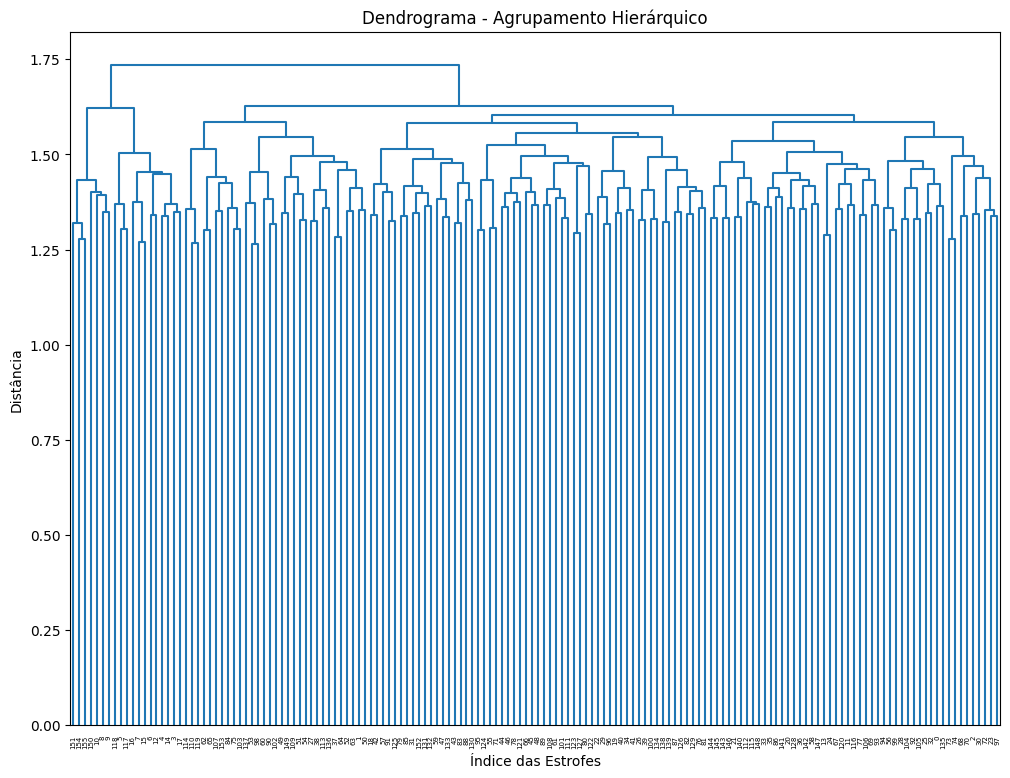

In [120]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Realizar o agrupamento hierárquico com AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
agg_clustering.fit(X_tfidf.toarray())

# Gerar o linkage matrix
Z = linkage(X_tfidf.toarray(), 'ward')

# Plotar o dendrograma
plt.figure(figsize=(12, 9))
dendrogram(Z, color_threshold=0)
plt.title("Dendrograma - Agrupamento Hierárquico")
plt.xlabel("Índice das Estrofes")
plt.ylabel("Distância")
plt.show()